<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2019/blob/master/2b_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 2b:  Optimisation for Deep Learning

© Deep Learning Indaba. Apache License 2.0.

## Introduction

In this practical, we will take a *deep* dive into an essential part of deep learning, and machine learning in general, **optimisation**. We'll take a look at the tools that allow as to turn a random collection of weights into a state-of-the-art model for any number of applications. More specifically, we'll implement a few standard optimisation algorithms for  finding the minimum of [Rosenbrock's banana function](https://en.wikipedia.org/wiki/Rosenbrock_function) and then we'll try them out on FashionMNIST.

## Learning Objectives

* Understand **what optimisation algorithms are**, and **how they are used** in the context of deep learning.
* Understand gradient descent, stochastic gradient descent, and mini-batch stochastic gradient descent.
* Understand the roles of batch size, learning rate and other hyper-parameters.
* Implement, using TF2.0, gradient descent and a few variations of it.
* Understand the strengths and weaknesses of the various optimisation algorithms covered in this practical.

In [0]:
#@title Imports (RUN ME!) { display-mode: "form" }

!pip install tensorflow-gpu==2.0.0-beta0 > /dev/null 2>&1

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
%matplotlib inline

display.clear_output()

print("TensorFlow executing eagerly: {}".format(tf.executing_eagerly()))

$$ 
\newcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\vechat}[1]{\hat{\mathbf{#1}}}
\newcommand{\x}{\vec{x}}
\newcommand{\utheta}{θ}
\newcommand{\th}{\vec{\utheta}}
\newcommand{\y}{\vec{y}}
\newcommand{\b}{\vec{b}}
\newcommand{\W}{\textrm{W}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\xhat}{\vechat{x}}
\newcommand{\yhat}{\vechat{y}}
\newcommand{\bhat}{\vechat{b}}
\newcommand{\What}{\hat{\W}}
\newcommand{\partialfrac}[2]{\frac{\partial{#1}}{\partial{#2}}}
\newcommand{\ipartialfrac}[2]{{\partial{#1}}/{\partial{#2}}}
\newcommand{\dydx}{\partialfrac{\y}{\x}}
\newcommand{\dld}[1]{\partialfrac{\L}{#1}}
\newcommand{\dldx}{\dld{\x}}
\newcommand{\dldy}{\dld{\y}}
\newcommand{\dldw}{\dld{W}}
\newcommand{\idld}[1]{\ipartialfrac{\L}{#1}}
\newcommand{\idldx}{\idld{\x}}
\newcommand{\idldy}{\idld{\y}}
\newcommand{\idydx}{\ipartialfrac{\y}{\x}}
\newcommand{\red}[1]{\color{red}{#1}}
\newcommand{\green}[1]{\color{green}{#1}}
\newcommand{\blue}[1]{\color{blue}{#1}}
\newcommand{\because}[1]{&& \triangleright \textrm{#1}}
\newcommand{\relu}[1]{\textrm{relu}({#1})}
\newcommand{\step}[1]{\textrm{step}({#1})}
\newcommand{\gap}{\hspace{0.5mm}}
\newcommand{\gapp}{\hspace{1mm}}
\newcommand{\ngap}{\hspace{-0.5mm}}
\newcommand{\ngapp}{\hspace{-1mm}}
$$

## Rosenbrock's Banana Function 🍌

In practice, when evaluating the performance of various optimisation algorithms and hyper-parameters, what we really care about is the performance on a wide range of real-world problems, in our case the optimisation of a loss function. However, we are not easily able to visualize what our algorithms are doing because the loss landscape for even simple neural networks trained on just about any real-world dataset will be very high-dimensional. 

To solve this problem, we will use Rosenbrock's (Banana) Function as a playground for investigating how these optimisation algorithms work. The banana function is easy to visualize because it is a function that takes a 2D ($x$ and $y$) input and returns a scalar output. It is defined as:

\begin{equation}
f(x,y) = (a-x)^2+b\times(y-x^2)^2
\end{equation}

where typical values for $a$ and $b$ are $1$ and $100$, respectively. For this practical we'll use $a = 1$ and $b = 20$. The global minimum of this function is at $(a, a^2)$ or $(1, 1)$ in our case. 

We can easily define this function using TensorFlow:

In [0]:
def rosenbrock_banana(x, y, a=1., b=20.):
  return tf.math.pow(a - x, 2.) + b * tf.math.pow(y - tf.math.pow(x, 2.), 2.)

Let's try visualizing the 🍌, first using a contour plot:

In [0]:
#@title Helper functions (RUN ME) (double click to unhide/hide the code)

def gen_2d_loss_surface(loss_func,
             n_x=100, # number of discretization points along the x-axis
             n_y=100, # number of discretization points along the x-axis
             min_x=-2., max_x=2., # extreme points in the x-axis
             min_y=-0.2, max_y=1.3 # extreme points in the y-axis
            ):
  
  # create a mesh of points at which to evaluate our function
  X, Y = np.meshgrid(np.linspace(min_x, max_x, n_x),
                     np.linspace(min_y, max_y, n_y))
  # evaluate the func at all of the points
  Z = loss_func(X, Y).numpy()
  
  return X, Y, Z
  
def make_contour_plot(X, Y, Z, levels=None):
  if levels == None:
    # generate 20 levels on a log scale
    levels = np.insert(np.logspace(0, 2.6, 20, True, base=10), 0, 0)
    
  fig = plt.figure(figsize=(9.84, 3))
  ax = fig.gca()
  
  ax.contour(X, Y, Z, levels, alpha=0.5)
  ax.contourf(X, Y, Z, levels, alpha=0.2)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  
  return fig, ax

def make_surface_plot(X, Y, Z, elevation=0, azimuth_angle=0, levels=None):
  
  if levels == None:
    # generate 20 levels on a log scale
    levels = np.insert(np.logspace(0, 2.6, 20, True, base=10), 0, 0)
    
  fig = plt.figure(figsize=(10,6))
  ax = fig.gca(projection='3d')
  ax.view_init(elevation, azimuth_angle)
  ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.2)
  ax.contour(X, Y, Z, levels, cmap='viridis', alpha=0.5)
  
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  
  return fig, ax


In [0]:
X, Y, Z = gen_2d_loss_surface(rosenbrock_banana)
fig, ax = make_contour_plot(X, Y, Z)

# add a marker to show the minimum
ax.plot(1, 1, 'r*', ms=30, label='minimum') 
ax.legend()

fig.show()

And now with a surface plot:

In [0]:
#@title {run: "auto"}

elevation = 62 #@param {type:"slider", min:0, max:360, step:1}
azimuth_angle = 117 #@param {type:"slider", min:0, max:360, step:1}
  
X, Y, Z = gen_2d_loss_surface(rosenbrock_banana)
fig, ax = make_surface_plot(X, Y, Z, elevation, azimuth_angle)

ax.plot([1], [1], 'r*', zs=[0], zdir='z', ms=30, label='minimum')
ax.legend()

fig.show()

As you can see, this is called the *banana* function because it contains a banana-shaped valley. Within the valley, we have a **global minimum**. Finding the valley is relatively easy, but finding the global minimum is difficult, which makes this a useful function for testing optimisation algorithms.

## Optimisation


### What is optimisation?

Optimisation is the process of comparing a set of items and selecting the best one, based on some metric. So, we can define an optimisation algorithm as a program (or series of instructions) that try to find the best item when compared to other items using a given method of comparison (or metric).

### How do we use it in machine learning?

Optimisation algorithms are used in machine learning to compare different values for the parameters of a model and to try to find the best one. For the banana function, the optimisation algorithm tries to find the x and y values that lead to the lowest value of the function (here our metric is: "lower values are better"). More practically, optimisation algorithms are used to try to find the best values for our neural network weights and biases. In this case, we use a *loss function* as a metric and try to select the weights and biases that lead to the lowest loss function value. But, we don't need to worry about that yet. First, we need to build up some tools that will let us do this.

**Note:** You may be wondering why we need special optimisation algorithms at all. For example, the minimum for the banana function above can be computed analytically. And indeed, for many optimisation problems, including some problems in machine learning such as linear regression, it is easy to compute solutions analytically. So why are we spending a whole practical on this topic? The reason is **computational complexity**. There are a huge number of problems, including optimising deep neural networks, for which we cannot find an analytical solution in a reasonable amount of time. In these cases, we need to find approximate solutions to our optimisation problems, which is what we will be looking at in this practical.

## Gradients

### What are gradient vectors?

*Note: feel free to skip this if you already understand what a gradient vector represents.*

Let's start with a scalar function $f$, which maps the input $x$ to the output $y$: $$y = \green{f(x)}$$

Here, $f$ could be a polynomial, exponential, or whatever your favorite kind of mathematical function is. 

Let's now  _approximate_ the function $\green f$ around a particular point $x_0$ with a straight-line function $\blue {d\ngap f}$:

$$\blue{d\ngap f(x)} = f(x_0) + \red{f'(x_0)}(x - x_0)$$

**Reminder:** the equation for a straight-line function can be given as: $y = m x + c$, where $m$ is the slope of the line and $c$ raises the function. If we want the function to go through a given point $(x_0, y_0)$, then we can change the equation to the following: $y = m (x - x_0) + y_0$. Notice, we just shifted the line along the $x$-axis and made sure the function is raised by $y_0$.

<center>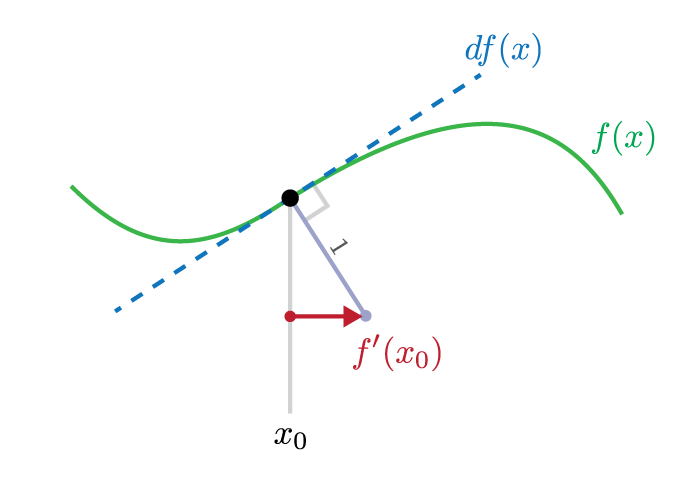</center>

As the picture above shows, we can use the derivative $f' = \frac{dy}{dx}$ to construct the best linear approximation to a function $f$ around a specific point $x_0$. Specifically, the derivative gives us the _slope_. If the function above was horizontal at $x_0$, you can see that the gradient $\red{f'(x_0)}$ would be zero.

Notice the _crucial_ fact that the gradient $\red{f'(x_0)}$ points in the _direction_ in which $\green{f(x)}$ _increases_, and the magnitude tells us _how quickly_ it increases. Here, the gradient is positive, which tells us the function is increasing to the *right*, and the large magnitude tells us it is increasing relatively quickly.

#### What did we just do?

Before we continue, let's make sure we know how this fits into the bigger picture. We just approximated some function (any function) $\green f$ with a straight line. Doing this gave us some important information: the direction in which the function is increasing $\red{f'(x_0)}$. In other words, what direction we should move $x_0$ in to find a higher value of our function $\green f$ - and an idea of how much we should move $x_0$.

In optimization, this is useful because we can use our function $\green f$ to *compare* different items, and we can use the direction $\red{f'(x_0)}$ to get *better* items. In this case, $\green f$ is our *metric* and the value $x_0$ is our current *item*. We then follow the direction $\red{f'(x_0)}$ to get a *better* item than $x_0$.

Below is an interactive version of the graphic. Play around with $x_0$ and build an intuition of how the gradient $\red{f'(x_0)}$ changes with the slope of the function $\green{f(x)}$.

In [0]:
#@title Helper functions (RUN ME) (double click to unhide/hide the code)
def f(x):
  return -np.cos(x)

def tangent_f(x):
  return np.sin(x)

def df(x, x_0):
  return tangent_f(x_0) * (x - x_0) + f(x_0)

def perpindicular_unit_f(x_0):
  slope_f = tangent_f(x_0)
  y_0 = f(x_0)
  
  x_1 = slope_f / np.sqrt(2) + x_0
  y_1 = -x_1 / slope_f + y_0 + x_0 / slope_f
  
  return [[x_0, x_1], [y_0, y_1]]

def interactive_gradient_visual(x_0):
  # change the fontsize for better visibility
  init_size = plt.rcParams["font.size"] # store initial font size
  plt.rcParams.update({'font.size': 22}) # update the size
  
  plt.figure(figsize=(12, 8))
  
  x = np.linspace(-np.pi, 2 * np.pi)
  f_x = f(x)
  
  # plot f(x)
  plt.plot(x, f_x, label=r"$f(x)$", color="green")
  
  # add a point showing where x_0 falls on f(x)
  plt.plot(x_0, f(x_0), marker="o", color="black")
  
  # plot the tangent line to f(x) at x_0
  plt.plot(x, df(x, x_0), linestyle="--", color="cornflowerblue", label=r"$df(x)$")
  
  # plot the normal vector to the tangent
  perp_unit_vector = perpindicular_unit_f(x_0)
  plt.plot(perp_unit_vector[0], perp_unit_vector[1], color="dimgray")
  
  # drop a vertical line from x_0
  plt.plot([x_0, x_0], [f(x_0), -3.1], color="silver")
  
  # plot the positive direction of change vector
  [[x_0, x_1], [y_0, y_1]] = perp_unit_vector
  dx = x_1 - x_0
  dy = 0 # y_1 - y_1
  arrow = plt.arrow(
      x_0, y_1, dx, dy,
      color="red", label=r"$f'(x_0)$",
      lw=3, head_width=np.abs(x_1 - x_0)/10, length_includes_head=True
  )
  plt.plot([x_0, x_1], [y_1, y_1], color="red", label=r"$f'(x_0)$")
  
  plt.legend(loc="upper left")
  plt.xlim(-3.1, 6.2)
  plt.ylim(-3.1, 3.1)
  plt.xlabel(r"$x_0$")
  plt.show()
  
  # reset to initial font size
  plt.rcParams.update({'font.size': init_size})

In [0]:
#@title Double click to unhide/hide the code {run: "auto"}
x_0 = 1.31 #@param {type:"slider", min:-3.1, max:6.2, step:0.01}

interactive_gradient_visual(x_0)

Again, notice how the gradient $\red{f'(x_0)}$ (the red arrow) always points in the direction where the funciton $\green{f(x)}$ is increasing. Also notice how the magnitude (length of the arrow) of the gradient $\red{f'(x_0)}$ increases when the slope increases.

### Moving to higher dimensions


In fact, a similar thing happens if we are working with a function whose input is a *vector* rather than a scalar. The same idea applies, but we must replace the multiplication between the *scalar* derivative $\red{ f'(x_0) }$ and the *scalar* difference $(x - x_0)$, with a dot product between the *vector* gradient $\red{\nabla f(\vec x_0)}$ and the _vector_ difference $(\vec x - \vec x_0)$:

$$\blue{d\hspace{-0.3ex}f(\x)} = f(\mathbf x_0) + \red{\nabla f(\mathbf x_0)}\gap\cdot \gap (\mathbf x - \mathbf x_0)$$

<center>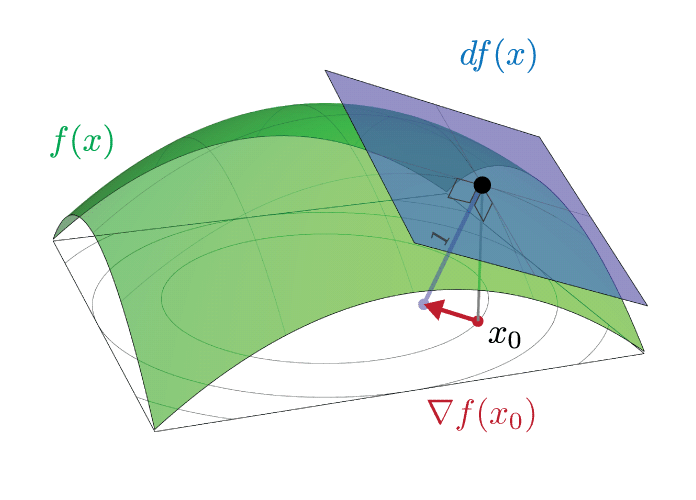</center>


As the picture above shows, this vector gradient represents the slope of the *plane* that approximates the surface of $f$ near the point $x_0$. The gradient points in the direction of steepest ascent ("the uphill direction"), and its magnitude tells us the steepness of the plane (so zero gradient means the plane is flat).

**Note**: the gradient points in the direction of *increase* of the function. For gradient descent (discussed next), we will instead be travelling in the direction of *decrease* of the loss. This means that our updates will simply be based on the negative of the gradient.

## Gradient Descent

Gradient descent is the simplest of training algorithms commonly used in deep learning. However, it gives excellent results in many cases, and also forms the basis for many other powerful optimization methods - such as Momentum, RMSProp, and Adam - which we will look at later in this practical. Mathematically we can describe gradient descent as follows:

\begin{equation}
\mathbf{θ}= \mathbf{θ} −\eta \times \nabla_\mathbf{θ} J(\mathbf{θ})
\end{equation}

where $\mathbf{θ}$ are the parameters of the model, $\eta$ (eta) is the learning rate, $J(\mathbf{θ})$ is the loss (also called $\mathcal{L}$), and $\nabla_\theta J(\mathbf{θ})$ is the **gradient** of the loss with respect to the parameters (similarl to $\red{\nabla f(\mathbf x_0)}$ in the example above). This equation tells us that to update each of the parameters, we scale the gradient for each parameter by the learning rate and subtract it from the corresponding parameter. Or, in pseudo-code:

```
for each epoch:
  grad = calc_grad(loss_func, data, params)  # Calculate gradient of loss wrt parameters
  params = params - learning_rate * grad
```

You might have noticed that we are sweeping a lot of critical details under the rug here! Firstly we are assuming that we can easily calculate the gradients using some `calc_grad` function, and secondly, we are ignoring the issue of batch size (the number of training data points we use to calculate an estimate of the gradient). 

Luckily for us, TensorFlow addresses the first detail thanks to **automatic differentiation** (AD). With AD, calculating the gradients is about as simple as calling a `calc_grad` function, which means that we do not need to worry about the details of *how* to calculate the gradients. We don't need to think much about implementing derivatives for each of our operations, or the backpropagation algorithm, for example. If you want to know more about how this all works, you should check out the *Build your own TensorFlow* tutorial.

In practice, batch size is simply a hyper-parameter that we can tune. However, there are three cases that are worth knowing about:

1.   Using a batch size of $n$, where $n$ is the number of training examples is known as **Batch Gradient Descent (BGD)**. In this case, all of the data is used to calculate the gradient at each step. This results in the *most accurate* estimate of the gradient. If the learning rate is not too high, BGD is guaranteed to converge to:
    * the global minimum for [convex](https://en.wikipedia.org/wiki/Convex_function) optimisation surfaces
    * a local minimum for non-convex surfaces (provided that there are no [saddle points](https://en.wikipedia.org/wiki/Saddle_point)).
    
    However, some downsides of BGD are that it is **not compatible with online learning**, where we get new examples during training, and that it can be slow for large training datasets.
    
  **Exercise:** what will happen if we use BGD with too high a learning rate on a convex optimisation surface? Will it diverge or find a local minimum? *Hint:* try drawing a diagram.


2.   Using a batch size of 1, called **Stochastic Gradient Descent (SGD)**. In this case, only a single data point is used to calculate an estimate of the gradient. Thus, the estimate is very noisy, and we are not guaranteed to find a minimum (local or global). However, SGD still performs very well in practice and allows for online learning. It also turns out that having noisy estimates of the gradient acts as a form of **regularisation** which can prevent over-fitting. Finally, because we are performing gradient descent with one example at a time, we need much less memory. Not having enough memory can be a significant issue when using BGD.


3.   Using a batch size of $m < n$ is called **Mini-batch Gradient Descent** and is a compromise between batch and stochastic gradient descent. We use $m$ examples to calculate an estimate of the gradient. Thus, we still have *some* noise in the gradient estimate, we can tune the batch size to make good use of memory, and the variance of the gradient estimate is greatly reduced — which leads to better convergence to local or global minima.

In deep learning, we almost always use mini-batch gradient descent. However, it is often referred to simply as SGD.






### Optional extra reading: choosing a batch size



You might be wondering how one chooses which batch size to use for a given problem.

One approach is to choose as big a batch size as possible. The reason we might want to do this is that a larger batch size means that our model will train more quickly. This speedup is because modern computer hardware, especially GPUs, are designed with parallelism in mind. In other words, by having a larger batch size, we can take better advantage of our hardware. So in practice, we often choose the largest batch size that will fit into memory.

[According to some research](https://arxiv.org/pdf/1803.09820.pdf), using a larger batch size allows you to select a higher learning rate - which means that your model will train faster. On the other hand, choosing too large a learning rate can lead to not converging to a minimum. So, we still have to tune the batch size.

You can read more about these issues in this [blog post](https://blog.janestreet.com/does-batch-size-matter/) as well as the paper linked above — the paper, in particular, discusses strategies for choosing various hyper-parameters related to optimisation in deep learning.

Let's look at the one dimensional straight-line aproximation example from above and see how the batch size affects the calculated gradient. In the plot below, we see the function $\green{f(x)}$, the true tangent line $\blue{df(x)}$, the true gradient $\blue{\tilde{f'}(x_0)}$, the calculated tangent line $\red{\tilde{df}(x)}$ and the calculated gradient $\red{\tilde{f'}(x_0)}$. In this case, we get the calculated tangent line $\red{\tilde{df}(x)}$ and gradient $\red{\tilde{f'}(x_0)}$ by using *batch_size* number of datapoints to calculate an estimate.

Change the values for $x_0$ and *batch_size* and see what you can learn.

In [0]:
#@title Helper functions (RUN ME) (double click to unhide/hide the code)
def f(x):
  return -np.cos(x)

def tangent_f(x):
  return np.sin(x)

def df(x, x_0):
  return tangent_f(x_0) * (x - x_0) + f(x_0)

def perpindicular_unit_f(x_0):
  slope_f = tangent_f(x_0)
  y_0 = f(x_0)
  
  x_1 = slope_f / np.sqrt(2) + x_0
  y_1 = -x_1 / slope_f + y_0 + x_0 / slope_f
  
  return [[x_0, x_1], [y_0, y_1]]

def noisy_df(x, x_0, noisy_x_0):
  return tangent_f(noisy_x_0) * (x - x_0) + f(x_0)

def noisy_perpindicular_unit_f(x_0, noisy_x_0):
  slope_f = tangent_f(noisy_x_0)
  y_0 = f(x_0)
  
  x_1 = slope_f / np.sqrt(2) + x_0
  y_1 = -x_1 / slope_f + y_0 + x_0 / slope_f
  
  return [[x_0, x_1], [y_0, y_1]]

def interactive_noisy_gradient_visual(x_0, noisy_x_0):
  # change the fontsize for better visibility
  init_size = plt.rcParams["font.size"] # store initial font size
  plt.rcParams.update({'font.size': 22}) # update the size
  
  plt.figure(figsize=(12, 8))
  
  x = np.linspace(-np.pi, 2 * np.pi)
  f_x = f(x)
  y_0 = f(x_0)
  
  # plot f(x)
  plt.plot(x, f_x, label=r"$f(x)$", color="green")
  
  # add a point showing where x_0 falls on f(x)
  plt.plot(x_0, f(x_0), marker="o", color="black")
  
  # plot the tangent line to f(x) at x_0
  plt.plot(x, df(x, x_0), linestyle="--", color="cornflowerblue", label=r"$df(x)$")
  
  # drop a vertical line from x_0
  plt.plot([x_0, x_0], [f(x_0), -3.1], color="silver")
  
  # plot the noisy tangent line to f(x) at x_0
  plt.plot(x, noisy_df(x, x_0, noisy_x_0), linestyle="--", color="red", label=r"$\widetilde{df}(x)$")
  
  # plot the normal vector to the tangent
  [[x_0, x_1], [y_0, y_1]] = perpindicular_unit_f(x_0)
  plt.plot([x_0, x_1], [y_0, y_1], color="dimgray")
  
  # plot the positive direction of change vector
  dx = x_1 - x_0
  dy = 0 # y_1 - y_1
  arrow = plt.arrow(
      x_0, y_1, dx, dy,
      color="blue", label=r"$f'(x_0)$",
      lw=3, head_width=np.abs(x_1 - x_0)/10, length_includes_head=True
  )
  plt.plot([x_0, x_1], [y_1, y_1], color="blue", label=r"$f'(x_0)$")
  
  # plot the noisy normal vector to the tangent
  [[noisy_x_0, x_1], [noisy_y_0, y_1]] = noisy_perpindicular_unit_f(x_0, noisy_x_0)
  plt.plot([x_0, x_1], [y_0, y_1], color="dimgray")
  
  # plot the noisy positive direction of change vector
  dx = x_1 - x_0
  dy = 0 # y_1 - y_1
  arrow = plt.arrow(
      x_0, y_1, dx, dy,
      color="red", label=r"$f'(x_0)$",
      lw=3, head_width=np.abs(x_1 - x_0)/10, length_includes_head=True
  )
  plt.plot([x_0, x_1], [y_1, y_1], color="red", label=r"$\widetilde{f'}(x_0)$")
  
  
  plt.legend(loc="upper left")
  plt.xlim(-3.1, 6.2)
  plt.ylim(-3.1, 3.1)
  plt.xlabel(r"$x_0$")
  plt.show()
  
  # reset to initial font size
  plt.rcParams.update({'font.size': init_size})

def interactive_batch_size_visual(x_0, batch_size):
  np.random.seed(0)
  noisy_x_0 = x_0 + np.mean(np.random.normal(loc=0, scale=0.5, size=batch_size))
  interactive_noisy_gradient_visual(x_0, noisy_x_0)

In [0]:
#@title Double click to unhide/hide the code {run: "auto"}
x_0 = 2.7 #@param {type:"slider", min:-3.1, max:6.2, step:0.01}
batch_size = 20 #@param {type:"slider", min:1, max:256, step:1}

interactive_batch_size_visual(x_0, batch_size)

**Exercise:** What are the general relationships you notice between the accuracy of the calculated gradient $\red{\tilde{f'}(x_0)}$ and (a) the batch size and (b) the funciton $\green{f(x)}$?

### Implementing SGD

SGD is incredibly simple to implement, and as you'll see later can perform very well!

In [0]:
def SGD_update(params, grads, states, hyper_params):
  # hyper-param typical values: learning_rate=0.01
  # SGD doesn't have any state, however, the algorithms
  # we will look at later do!
  for param, grad in zip(params, grads):
    param.assign_sub(hyper_params['lr'] * grad)

And now we can visualize each step of the SGD optimization:

**Exercise:** Take a look at the hidden code below and make sure that you understand it. Do you see how the code relates to the pseudo-code and equation above? For example, where do you find `calc_grad`? Once you understand the code, you should hide it again to make it easier to change the sliders and see the results.

In [0]:
#@title Helper functions (RUN ME) (double click to unhide/hide the code)

def optimize_banana(update_func, params, states, hyper_params):
  # plot the loss surface, minimum value and starting point
  X, Y, Z = gen_2d_loss_surface(rosenbrock_banana)
  fig, ax = make_contour_plot(X, Y, Z)
  ax.plot(1, 1, 'r*', ms=30, label='minimum') 
  ax.plot(start_x, start_y, 'b*', ms=20, label='start')

  for epoch in range(epochs):
    with tf.GradientTape() as tape:
      # we are trying to minimize the output of the 🍌 func
      loss = rosenbrock_banana(x, y) 
    # calculate the gradients of the loss with respect to the params
    grads = tape.gradient(loss, params)

    # save the old x and y values for the plot
    old_x = params[0].numpy()
    old_y = params[1].numpy()

    # update the parameters using SGD
    update_func(params, grads, states, hyper_params)

    # plot the change in x and y for each update step
    ax.annotate('', xy=(x.numpy(), y.numpy()),
                xytext=(old_x, old_y),
              arrowprops={'arrowstyle': '->', 'color': 'k', 'lw': 1},
                   va='center', ha='center')  

  ax.plot(x.numpy(), y.numpy(), 'g*', ms=20, label='end')
  ax.legend()

  fig.show()

In [0]:
#@title Double click to unhide/hide the code {run: "auto"}
start_x = -1 #@param {type:"slider", min:-2, max:2, step:0.1}
start_y = 0.73334 #@param {type:"slider", min:-0.26666, max:1.0666, step:0.1}
learning_rate = 0.015 #@param {type:"slider", min:0, max:0.02, step:0.0005}
epochs = 150 #@param {type:"slider", min:1, max:150, step:1}

x = tf.Variable(start_x, dtype='float32')  
y = tf.Variable(start_y, dtype='float32')
params = [x, y]
states = []
hyper_params = {"lr": learning_rate}

optimize_banana(SGD_update, params, states, hyper_params)

**Partner Exercise:** Tweak the starting position (x and y), as well as the learning rate and the number of epochs. See if you can get to the global minimum. What do you notice about the behaviour of SGD in the 🍌 valley?

## SGD with Momentum

Hopefully, you've noticed a bit of an issue with SGD. When the gradient is small (i.e. in the 🍌) the changes to the parameters become very small and progress towards the minimum is very slow. One solution to this problem is to add a momentum term to our optimization step:

\begin{align}
\Delta \mathbf{θ} &= \gamma \Delta \mathbf{θ} + \eta \nabla_\mathbf{θ} J(\mathbf{θ}) \\
\mathbf{θ} &= \mathbf{θ} − \Delta \mathbf{θ}
\end{align}

where $\Delta \mathbf{θ}$ is the change in parameters $\mathbf{θ}$ at each step and is made up of a mixture between the gradients at a given step and the change from the previous step. $\gamma$ (gamma) is called the *momentum* term, and $\eta$ is called the learning rate, as before.

The reason that this method is called *momentum* is that we can compare it to SGD as follows:

> Gradient descent is a person walking down a hill. They follow the steepest path downwards; their progress is slow, but steady. Momentum is a heavy ball rolling down the same hill. The added inertia acts both as a smoother and an accelerator, dampening oscillations and causing it to barrel through narrow valleys, small humps and local minima. 

In other words, **the momentum term speeds up optimisation if the direction of change stays more or less the same and reduces oscillations when the direction of change goes back and forth**.

We can also describe momentum with some simple pseudo-code:

```
change = 0
for each epoch:
  grad = calc_grad(loss_func, data, params)
  change = momentum * change + learning_rate * grad
  params = params - change
```

### Implementing Momentum

In [0]:
def momentum_update(params, grads, states, hyper_params):
  # hyper-param typical values: learning_rate=0.01, momentum=0.9
  changes = states['changes']
  for param, grad in zip(params, grads):
    changes[param].assign(hyper_params['momentum'] * changes[param] +
                          hyper_params['lr'] * grad)
    param.assign_sub(changes[param])

In [0]:
#@title Double click to unhide/hide the code{run: "auto"}
start_x = -1 #@param {type:"slider", min:-2, max:2, step:0.1}
start_y = 0.73334 #@param {type:"slider", min:-0.26666, max:1.0666, step:0.1}
learning_rate = 0.01 #@param {type:"slider", min:0, max:0.02,step:0.0005}
momentum = 0.8 #@param {type:"slider", min:0, max:0.99, step:0.01}
epochs = 50 #@param {type:"slider", min:1, max:150,step:1}

x = tf.Variable(start_x, dtype='float32')  
y = tf.Variable(start_y, dtype='float32')
params = [x, y]
changes = {param: tf.Variable(0., dtype='float32') for param in params}
hyper_params = {"lr": learning_rate, "momentum": momentum}
states = {"changes": changes}

optimize_banana(momentum_update, params, states, hyper_params)

**Partner Exercise:** Play around with the various parameters and see if you can get to the minimum. Compare the performance of momentum in the 🍌 to that of SGD.

**Partner Exercise:** Why do we see oscillations for high enough momentum values?

**Partner Exercise:** Do you see any relationship between the amount of momentum and the learning rate?


## RMSProp (Root Mean Square Propagation)

So far, we have chosen a learning rate $\eta$, and it has been multiplied by the whole gradient. Thus, each element in the gradient vector has had the same learning rate applied to it at every step. However, we can imagine that:

1.   Each weight might not need to vary by the same amount.
2.   The amount we want to change each parameter might change throughout the optimisation process. 

**Exercise:** can you think of examples of when these two cases might apply?

RMSProp is a method that addresses these issues. It can be described with the following formulae:

\begin{align}
\mathbf{v} &= \gamma \mathbf{v} + (1 - \gamma) (\nabla_\mathbf{θ} J(\mathbf{θ}))^2 \\
\mathbf{θ} &= \mathbf{θ} − \frac{\eta}{\sqrt{\mathbf{v}} + \mathbf{\epsilon}} \nabla_\mathbf{θ} J(\mathbf{θ})
\end{align}

where each element of $\mathbf{v}$ is an estimate of the square of the gradient for a specific parameter, calculated using a rolling average, $\gamma$ is a forgetting factor for the rolling average, and $\mathbf{\epsilon}$ (epsilon) is a small number added for numerical stability. 

In words, RMSProp is scaling down the learning rate for each gradient by rolling average of the most recent gradients for that parameter. Importantly **each parameter has its own learning rate, which changes over time**.

We can also describe RMSPRop using pseudo-code:

```
average = 0
for each epoch:
  grad = calc_grad(loss_func, data, params)
  average = gamma * average + (1 - gamma) * pow(grad, 2)
  params = params - learning_rate / sqrt(average) * grad
 ```

### Implementing RMSProp

In [0]:
def RMSProp_update(params, grads, states, hyper_params):
  # hyper-param typical values: learning_rate=0.001, gamma=0.9, eps=1e-8
  averages = states['averages']
  for param, grad in zip(params, grads):
    averages[param].assign(hyper_params['gamma']*averages[param] +
                           (1 - hyper_params['gamma'])*tf.math.pow(grad, 2))
    param.assign_sub(hyper_params['lr']/(tf.sqrt(averages[param]) + hyper_params['eps'])*grad)

In [0]:
#@title Double click to unhide/hide the code {run: "auto"}
start_x = -1 #@param {type:"slider", min:-2, max:2, step:0.1}
start_y = 0.73334 #@param {type:"slider", min:-0.26666, max:1.0666, step:0.1}
learning_rate = 0.01 #@param {type:"slider", min:0, max:0.02,step:0.0005}
gamma = 0.9 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
epochs = 150 #@param {type:"slider", min:1, max:150,step:1}

x = tf.Variable(start_x, dtype='float32')  
y = tf.Variable(start_y, dtype='float32')
params = [x, y]
averages = {param: tf.Variable(0., dtype='float32') for param in params}
states = {"averages": averages}
hyper_params = {"lr": learning_rate, "gamma": gamma, "eps": 1e-8}
  
optimize_banana(RMSProp_update, params, states, hyper_params)

**Partner Exercise:** Play around with the various parameters and see if you can get to the minimum. Compare the performance of RMSProp with momentum and SGD, particularly in the 🍌.

## Adam (Adaptive moment estimation)

Adam combines the ideas of momentum and adaptive learning rates that we have explored above. More specifically, in addition to storing the rolling averages of the *squared* gradients and using them to control the learning rate for each parameter, like RMSProp, it also stores the rolling averages of the gradients themselves and uses them like momentum. Mathematically, we can describe Adam as follows:

\begin{align}
\mathbf m &= β_1 \mathbf{m} + (1 − β_1)  \nabla_\mathbf{θ} J(\mathbf{θ}) \\
\mathbf v &= β_2 \mathbf{v} + (1 − β_2) (\nabla_\mathbf{θ} J(\mathbf{θ}))^2 \\
\mathbf{\hat{m}} &= \frac{\mathbf{m}}{1 − β_1^t} \\
\mathbf{\hat{v}} &= \frac{\mathbf{v}}{1 − β_2^t} \\
\mathbf{θ} &= \mathbf{θ} − \frac{\eta}{\sqrt{\mathbf{\hat{v}}} + \mathbf{\epsilon}} \mathbf{\hat{m}}
\end{align}

where $\mathbf{m}$ is a rolling estimate of the gradient, $\mathbf{v}$ is a rolling estimate of the squared gradient,  $\mathbf{\hat{m}}$ and $\mathbf{\hat{v}}$ are bias-corrected estimates, and the $\beta_i$ (beta) are mixing factors. As before, $\eta$ and $\epsilon$ are the learning rate and a numerical stability term.

The name Adam comes from the fact that $\mathbf{m}$ and $\mathbf{v}$ are estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradient. The reason that we need bias corrected versions of the estimates is that they are initialized to be zero vectors, which means that when the training starts, the estimates are biased towards zero. This problem is especially relevant when $β_1$ and $β_2$ are close to 1.

The pseudo-code for Adam is slightly longer than the other methods we've looked at but should be reasonably simple to understand. If something doesn't make sense, go back and look at momentum and RMSProp.

```
first_moment = 0
second_moment = 0
t = 0
for each epoch:
  t = t + 1
  grad = calc_grad(loss_func, data, params)
  first_moment  = beta1 * first_moment  + (1 - beta1) * grad
  second_moment = beta2 * second_moment + (1 - beta2) * pow(grad, 2)
  first_moment_unbiased  = first_moment  / (1 - pow(beta1, t))
  second_moment_unbiased = second_moment / (1 - pow(beta2, t))
  params = params - (learning_rate / sqrt(second_moment_unbiased)) * first_moment_unbiased
```

### Implementing Adam

Implementing Adam is left as an exercise, we've set up the schafolding for you but you'll have to get your hands dirty! So skip this section for now, and come back later!

In [0]:
def Adam_update(params, grads, states, hyper_params):
  # hyper-param typical values: learning_rate=0.001, beta1=0.9, beta2=0.999, eps=1e-8
  t = states["t"]
  t.assign_add(1.0)  
  first_moments = states["first_moments"]
  second_moments = states["second_moments"]
  
  for param, grad in zip(params, grads):
    # come back here later!
    

In [0]:
#@title Double click to unhide/hide the code {run: "auto"}
start_x = -1 #@param {type:"slider", min:-2, max:2, step:0.1}
start_y = 0.73334 #@param {type:"slider", min:-0.26666, max:1.0666, step:0.1}
learning_rate = 0.01 #@param {type:"slider", min:0, max:0.02,step:0.0005}
beta1 = 0.8 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
beta2 = 0.8 #@param {type:"slider", min:0.01, max:0.999, step:0.001}
epochs = 150 #@param {type:"slider", min:1, max:150,step:1}

x = tf.Variable(start_x, dtype='float32')  
y = tf.Variable(start_y, dtype='float32')
params = [x, y]
first_moments = {param: tf.Variable(0., dtype='float32')
                 for param in params}
second_moments = {param: tf.Variable(0., dtype='float32')
                                     for param in params}
t = tf.Variable(0., dtype='float32')
states = {"first_moments": first_moments, 
          "second_moments": second_moments, "t": t}
hyper_params = {"lr": learning_rate, "beta1": beta1, "beta2": beta2, "eps": 1e-8}

optimize_banana(Adam_update, params, states, hyper_params)

## Learning Rate Decay

One of the advantages of methods such as Adam and RMSProp is that the effective learning rate for each parameter is no longer a constant during training. This behaviour is desirable because we often want to reduce the learning rate as we near the global minimum so that we do not overshoot it. Another simple strategy for solving this problem is *learning rate decay*. With learning rate decay, we progressively reduce the learning rate during the training process. For example, we might decay our learning rate as follows:

\begin{equation}
  \eta = \eta \times \frac{1}{1 + \delta \times t}
\end{equation}

where $\eta$ is the learning rate, $\delta$ (delta) is the decay rate, and $t$ is the number of the current training epoch. This method will give us a learning rate that looks something like this:

In [0]:
initial_learning_rate = 0.01
epochs = 100
decay_rate = initial_learning_rate/epochs
learning_rates = [initial_learning_rate]

for t in range(epochs):
  previous_learning_rate = learning_rates[t]
  learning_rate_at_t = previous_learning_rate * 1/(1 + decay_rate * t)
  learning_rates.append(learning_rate_at_t)
  
plt.plot(learning_rates)
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("LR vs Epoch")
plt.show()

In practice, while we do often use the simple decay scheme shown above, it is also common to use more complicated *learning rate schedules* such as exponential decay and step decay:

In [0]:
# exponential decay
initial_learning_rate = 0.01
epochs = 100
decay_rate = 0.01
learning_rates = []

for t in range(epochs):
  learning_rate_at_t = initial_learning_rate * np.exp(-decay_rate * t)
  learning_rates.append(learning_rate_at_t)
  
plt.plot(learning_rates)
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("LR vs Epoch")
plt.show()

In [0]:
# step decay
initial_learning_rate = 0.01
epochs = 100
epochs_wait = 10
decay_rate = 0.5
learning_rates = []

for t in range(epochs):
  exponent = np.floor((1 + t) / epochs_wait) # this part gives us the "steps"
  learning_rate_at_t = initial_learning_rate * np.power(decay_rate, exponent)
  learning_rates.append(learning_rate_at_t)
  
plt.plot(learning_rates)
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("LR vs Epoch")
plt.show()

Any of these learning rate decay methods are compatible with the optimisation methods described above. The choices of whether or not to use learning rate decay and if so, which method to use, are hyper-parameters that we can tune.


## Putting it all into practice

Putting all of this into practice is very simple! Keras provides us with a high-level API that makes using any of the optimization methods or learning rate schedules as easy as changing a single line of code. Of course, if you are defining a custom training loop using `tf.GradientTape` then the code we've used above can easily be converted to work for any model and dataset. 

One of the advantages of using Keras is that it provides us with reasonable default values for all of the hyper-parameters of the optimization algorithms. Let's use Keras to train a simple MLP on FashionMNIST so that we can compare the optimization algorithms we've looked at in a more realistic setting.

As a quick reminder, FashionMNIST contains 28x28 grayscale images from 10 different types of clothing. Let's take a quick look:

In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_index = np.random.randint(0, 50000)
    plt.imshow(train_images[img_index], cmap="gray_r")
    plt.xlabel(text_labels[train_labels[img_index]])

Before we train on the data, we want to do a little pre-processing. We won't go into detail about how and why we are doing the pre-processing, but if you want to know more, you should take a look at the *Deep Feedforward Networks* practical.

In [0]:
batch_size = 128

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# Divide image values and cast to float so that they end up as a floating point number between 0 and 1
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)))
# Shuffle the examples.
train_ds = train_ds.shuffle(buffer_size=batch_size * 10)
# Now "chunk" the examples into batches
train_ds = train_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)))
test_ds = test_ds.batch(batch_size)

Now let's define a simple MLP:

In [0]:
def build_mlp():
  model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
  ])
  
  return model

model = build_mlp()

model.summary()

And finally, lets train the MLP using a few different optimisers and compare the results:

In [0]:
#@title Helper functions (double click to unhide/hide the code)

def make_loss_plots(losses):
  plt.close()
  for label, loss_vals in losses.items():
    plt.plot(loss_vals, label=label)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss vs Epoch")
  plt.legend()
  plt.show()

In [0]:
losses = {}
tf.random.set_seed(0)

# SGD
model = build_mlp()
model.compile(optimizer='sgd', 
              # we can use the string shortcut if we 
              # don't want to change the hyper-parameters
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
sgd_hist = model.fit(train_ds, epochs=5,
          validation_data=test_ds)

losses['SGD'] = sgd_hist.history["val_loss"]
make_loss_plots(losses)



# Momentum
model = build_mlp()
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
momentum_hist = model.fit(train_ds, epochs=5,
          validation_data=test_ds)

losses['Momentum'] = momentum_hist.history["val_loss"]
make_loss_plots(losses)

# RMSProp
model = build_mlp()
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9),
              # rho is the symbol used for the forget factor in Keras
              # we used gamma (γ) in this practical
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
rmsprop_hist = model.fit(train_ds, epochs=5,
          validation_data=test_ds)

losses['RMSProp'] = rmsprop_hist.history["val_loss"]
make_loss_plots(losses)

# Adam
# UNCOMMENT THIS ONCE YOU HAVE IMPLEMENTED ADAM!
# model = build_mlp()
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
# adam_hist = model.fit(train_ds, epochs=5,
#           validation_data=test_ds)

# losses['Adam'] = adam_hist.history["val_loss"]
# make_loss_plots(losses)

# SGD with learning rate decay
model = build_mlp()
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.5, momentum=0.0, decay=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
sgd_decay_hist = model.fit(train_ds, epochs=5,
          validation_data=test_ds)

losses['SGD with decay'] = sgd_decay_hist.history["val_loss"]
make_loss_plots(losses)

# Momentum with learning rate decay
model = build_mlp()
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.5, momentum=0.9, decay=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
sgd_decay_hist = model.fit(train_ds, epochs=5,
          validation_data=test_ds)

losses['Momentum with decay'] = sgd_decay_hist.history["val_loss"]
make_loss_plots(losses)

**Exercise:** Play with the parameters of the various optimisers and see how that affects this particular problem.

**Note:** There is an element of randomness each time we train our models; this means that we should be careful when making judgements about which methods are best for this problem.

## Optional extra reading: second-order methods

All of the optimization methods we've looked at in this practical are what we call first order methods: they calculate a straight line estimate of the gradient and take a step in that direction. However, this straight line estimate throws away some useful information about the curvature of our loss surface. In other words, a first order method gives us information about whether or not our loss is increasing or deacresing in a given direction, but a second order method tells us how much it is increasing or decreasing. With this extra information, second order methods can find a minima in fewer steps, and have less trouble with getting stuck in saddle points.

Unfortunately, the benefits of second-order methods come at a cost. As you might have guessed from the names, a first-order method calculates the first derivative of our loss function, while a second-order method also calculates the second derivative. Calculating these second derivatives (the [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix)) is computationally expensive, which means that second-order methods are often slower in practice. For this reason, we usually do not see second-order methods in deep learning. However, fast approximations for second-order methods are an active area of research!

Examples of second-order methods include [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) and [BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm).

## Conclusion:

### What are optimisers, and how do we use them?

Optimisers are algorithms that try to find the best item when compared to other items using a given method of comparison (or metric). In deep learning, we use them to try to find the best values for our weights and biases, using a loss function as our metric.

### What method should you use?

There are **no hard rules** for which methods you should use. It will always depend on your particular model and dataset. However, some guidelines are worth keeping in mind:

1. Adam typically works very well in a large number of settings and is usually a good first choice.
2. RMSProp can often outperform Adam for RNNs as well as in RL. If you are working in either of these domains, then it might be worth trying RMSProp.
3. SGD and SGD with momentum often work just as well as more sophisticated methods like Adam. Don't think that they aren't worth trying out just because they are simple.

## Tasks

1. **[All]** Combine the implementations for momentum and RMSProp to implement Adam. Experiment with the parameters of Adam and compare it to the previous methods we have looked at.
2. **[All]** Augment any of the optimization methods with learning rate decay. You can choose any of the learning rate decay methods. Play around with the parameters. Compare the performance of the optimization method with and without learning rate decay.
3. **[Optional, Intermediate]** Implement the other two learning rate decay methods and compare all three decay methods with one another.
4. **[Optional, Advanced]** Implement Nesterov Momentum. You can read more about it [here](http://ruder.io/optimizing-gradient-descent/).
5. **[Optional, Advanced]** Implement Nadam. You can read more about it [here](http://ruder.io/optimizing-gradient-descent/) (it also works particularly well in deep RL).





## Extra resources

* A [blog post](http://fa.bianp.net/teaching/2018/eecs227at/gradient_descent.html) from Fabian Pedregosa on gradient descent [**Highly Recommended**].
* [Distil.pub post](https://distill.pub/2017/momentum/) by Gabriel Goh on why momentum works [**Highly Recommended**].
* [Sebastian Ruder's blog](http://ruder.io/optimizing-gradient-descent/) on gradient descent algorithms.
* Deep Dive into Deep Learning chapter on [Optimization Algorithms](http://d2l.ai/chapter_optimization/index.html).
* Keras optimizer [docs](https://keras.io/optimizers/).
